In [1]:
import pandas as pd
import re
import random
import spacy
from spacy.util import minibatch, compounding
import en_core_web_lg
import warnings
import matplotlib.pyplot as plt
import string

Matplotlib is building the font cache; this may take a moment.


In [119]:
food_df = pd.read_csv("data/food.csv")
food_df.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13
4,1105898,experimental_food,Discrepancy between the Atwater factor predict...,NaN,2020-10-30


In [120]:
# diaqualify foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

# filter out foods with more than 3 words, drop any duplicates
foods = foods[foods.str.split().apply(len) <= 3].drop_duplicates()
# foods = foods[foods.str.split('\s+')]
# print the remaining size
foods.size

42018

In [121]:
foods.head()

1          swanson broth beef
9       swanson broth chicken
31    pepperidge farm cookies
41      pepperidge farm bread
48    swanson broth vegetable
Name: description, dtype: object

In [85]:
#foods.to_csv('foods_clean.csv')

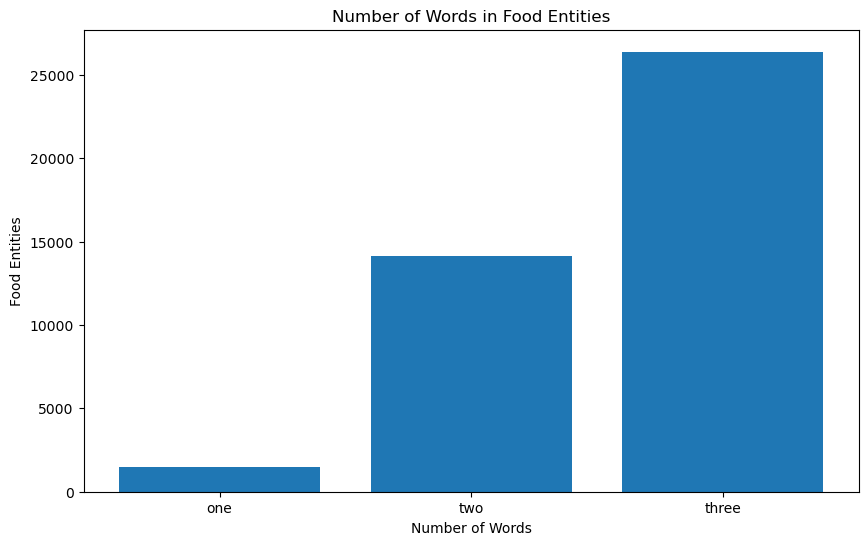

In [123]:
# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]

# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")

# display the plot
plt.show()

In [124]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)

# append the foods together 
foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)

1-worded food entities: 1490
2-worded food entities: 993
3-worded food entities: 828


/tmp/ipykernel_17549/578531204.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])
/tmp/ipykernel_17549/578531204.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])


In [125]:
food_templates = [
    "I ate my {}",
    "I'm eating a {}",
    "I just ate a {}",
    "I only ate the {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "I just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "I ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "I ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "I made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "I decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "I ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "I devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge"
]

In [126]:
# create dictionaries to store the generated food combinations. Do note that one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 167

# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["three_foods"],
    }[count]

# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append

        if len(entities) == 0:
            entities.append((match_span[0], match_span[1], "FOOD"))
        else:
            for span0, span1, _ in entities:
                if match_span[0] != span0:
                    entities.append((match_span[0], match_span[1], "FOOD"))
    
    entities = list(set(entities))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))

In [127]:
for key in TRAIN_FOOD_DATA:
    print("{} {} sentences: {}".format(len(TRAIN_FOOD_DATA[key]), key, TRAIN_FOOD_DATA[key][0]))

167 one_food sentences: ('I just ate a fingers sprinkles', {'entities': [(13, 30, 'FOOD')]})
167 two_foods sentences: ('I ate a jumbo cheeseburger and a nori for lunch', {'entities': [(8, 26, 'FOOD'), (33, 37, 'FOOD')]})
167 three_foods sentences: ('I took a sriracha pesto, gummi worms and cherries on the weekend', {'entities': [(25, 36, 'FOOD'), (41, 49, 'FOOD'), (9, 23, 'FOOD')]})


In [128]:
for key in TEST_FOOD_DATA:
    print("{} {} items: {}".format(len(TEST_FOOD_DATA[key]), key, TEST_FOOD_DATA[key][0]))

1036 one_food items: ('I ate a couple of syrup  last night', {'entities': [(18, 24, 'FOOD')]})
268 two_foods items: ('today I ate a navy beans and a piccalilli pickle for lunch', {'entities': [(31, 48, 'FOOD'), (14, 24, 'FOOD')]})
245 three_foods items: ("There's a basket of enriched steak rolls, midgees and blueberry pie bread that I consumed", {'entities': [(54, 73, 'FOOD'), (20, 40, 'FOOD'), (42, 49, 'FOOD')]})


In [129]:
import nltk
nltk.download("brown")

[nltk_data] Downloading package brown to /home/s2478846/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [130]:
from nltk.corpus import brown

In [131]:
article = []
sentences = brown.sents(categories='news')[:10000]
for i, sentence in enumerate(sentences):
    sent = ' '.join(sentence)
    sent = sent.translate(str.maketrans('','', string.punctuation))
    article.append(sent)
    # print(sentence)

In [132]:
npr_df = pd.DataFrame({'Article': article})

In [133]:
npr_df.head()

,Article
0,The Fulton County Grand Jury said Friday an in...
1,The jury further said in termend presentments ...
2,The SeptemberOctober term jury had been charge...
3,Only a relative handful of such reports was r...
4,The jury said it did find that many of Georgia...


In [134]:
nlp = en_core_web_lg.load()

In [135]:
revision_texts = []

# convert the articles to spacy objects to better identify the sentences. Disabled unneeded components. # takes ~ 4 minutes
for doc in nlp.pipe(npr_df["Article"][:6000], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc.sents:
        if  40 < len(sentence.text) < 80:
            # some of the sentences had excessive whitespace in between words, so we're trimming that
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))

In [136]:
revisions = []

# Use the existing spaCy model to predict the entities, then append them to revision
for doc in nlp.pipe(revision_texts, batch_size=50, disable=["tagger", "parser"]):
    
    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

In [137]:
# print an example of the revision sentence
print(revisions[0][0])

# print an example of the revision data
print(revisions[0][1])

Regarding Atlantas new multimilliondollar airport 
{'entities': [(10, 18, 'ORG')]}


In [138]:
# create arrays to store the revision data
TRAIN_REVISION_DATA = []
TEST_REVISION_DATA = []

# create dictionaries to keep count of the different entities
TRAIN_ENTITY_COUNTER = {}
TEST_ENTITY_COUNTER = {}

# This will help distribute the entities (i.e. we don't want 1000 PERSON entities, but only 80 ORG entities)
REVISION_SENTENCE_SOFT_LIMIT = 100

# helper function for incrementing the revision counters
def increment_revision_counters(entity_counter, entities):
    for entity in entities:
        label = entity[2]
        if label in entity_counter:
            entity_counter[label] += 1
        else:
            entity_counter[label] = 1

random.shuffle(revisions)
for revision in revisions:
    # get the entities from the revision sentence
    entities = revision[1]["entities"]

    # simple hack to make sure spaCy entities don't get too one-sided
    should_append_to_train_counter = 0
    for _, _, label in entities:
        if label in TRAIN_ENTITY_COUNTER and TRAIN_ENTITY_COUNTER[label] > REVISION_SENTENCE_SOFT_LIMIT:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1

    # simple switch for deciding whether to append to train data or test data
    if should_append_to_train_counter >= 0:
        TRAIN_REVISION_DATA.append(revision)
        increment_revision_counters(TRAIN_ENTITY_COUNTER, entities)
    else:
        TEST_REVISION_DATA.append(revision)
        increment_revision_counters(TEST_ENTITY_COUNTER, entities)


In [139]:
TRAIN_ENTITY_COUNTER

{'ORG': 114,
 'DATE': 127,
 'PERSON': 164,
 'GPE': 106,
 'CARDINAL': 107,
 'QUANTITY': 11,
 'NORP': 42,
 'ORDINAL': 36,
 'FAC': 20,
 'MONEY': 13,
 'LOC': 16,
 'TIME': 21,
 'LANGUAGE': 4,
 'PERCENT': 3,
 'EVENT': 4,
 'WORK_OF_ART': 6,
 'PRODUCT': 5,
 'LAW': 2}

In [140]:
TEST_ENTITY_COUNTER

{'PERSON': 300,
 'ORG': 210,
 'LOC': 2,
 'GPE': 80,
 'DATE': 125,
 'TIME': 4,
 'WORK_OF_ART': 1,
 'CARDINAL': 148,
 'FAC': 2,
 'QUANTITY': 1,
 'ORDINAL': 4,
 'NORP': 6,
 'PRODUCT': 2,
 'PERCENT': 1}

In [141]:
# combine the food training data
TRAIN_FOOD_DATA_COMBINED = TRAIN_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]

# print the length of the food training data
print("FOOD", len(TRAIN_FOOD_DATA_COMBINED))

# print the length of the revision training data
print("REVISION", len(TRAIN_REVISION_DATA))

# join and print the combined length
TRAIN_DATA = TRAIN_REVISION_DATA + TRAIN_FOOD_DATA_COMBINED
print("COMBINED", len(TRAIN_DATA))

FOOD 501
REVISION 435
COMBINED 936


In [142]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [144]:

# nlp = spacy.blank('en')
# if 'ner' not in nlp.pipe_names:
#     ner = nlp.create_pipe("ner")
#     nlp.add_pipe(ner, last=True)
    
# for _, annotations in TRAIN_DATA:
#     for ent in annotations['entities']:
#         ner.add_label(ent[2])

# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

# get the names of the components we want to disable during training
# pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

# start the training loop, only training NER
epochs = 30
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    
    # batch up the examples using spaCy's minibatc
    for epoch in range(epochs):
        examples = TRAIN_DATA
        random.shuffle(examples)
        batches = minibatch(examples, size=sizes)
        losses = {}
        
        for batch in batches:
            texts, annotations = zip(*batch)
            # print(texts)
            # try:
            nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
            # except Exception as error:
            #     print(error)
            #     continue

        print("Losses ({}/{})".format(epoch + 1, epochs), losses)

/data/s2478846/conda/envs/vlp/lib/python3.8/site-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "I ate a rosemary with apricot mustard glaze  in th..." with entities "[(22, 44, 'FOOD'), (8, 16, 'FOOD')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/data/s2478846/conda/envs/vlp/lib/python3.8/site-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "There's pistachios  for breakfast in the bowl this..." with entities "[(8, 19, 'FOOD')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/data/s2478846/conda/envs/vlp/lib/python3.8/site-packages/spacy/language.py:482: UserWarning: [W030] S

Losses (1/30) {'ner': 6865.535072769428}
Losses (2/30) {'ner': 6322.315588503858}
Losses (3/30) {'ner': 6013.2584727292415}
Losses (4/30) {'ner': 5903.926022073254}
Losses (5/30) {'ner': 5816.097451763693}
Losses (6/30) {'ner': 5814.300892004743}
Losses (7/30) {'ner': 5686.641056919936}
Losses (8/30) {'ner': 5793.508453631068}
Losses (9/30) {'ner': 5724.086024272256}
Losses (10/30) {'ner': 5711.498460925184}
Losses (11/30) {'ner': 5653.116195980925}
Losses (12/30) {'ner': 5559.8016498943325}
Losses (13/30) {'ner': 5596.82005363889}
Losses (14/30) {'ner': 5605.7816534198355}
Losses (15/30) {'ner': 5694.852554613826}
Losses (16/30) {'ner': 5660.59294475615}
Losses (17/30) {'ner': 5680.054303069366}
Losses (18/30) {'ner': 5576.239819250186}
Losses (19/30) {'ner': 5588.503283847589}
Losses (20/30) {'ner': 5554.915339077532}
Losses (21/30) {'ner': 5601.046177541139}
Losses (22/30) {'ner': 5529.638570401337}
Losses (23/30) {'ner': 5529.585226745112}
Losses (24/30) {'ner': 5448.063485867075}


In [145]:
# display sentences involving target entity
spacy.displacy.render(nlp("I had a hamburger and chips for lunch today."), style="ent")
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a little treat for myself."), style="ent")
spacy.displacy.render(nlp("I ordered basmati rice, leaf spinach and cheese from Tesco yesterday"), style="ent")

In [146]:
# dictionary to hold our evaluation data
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
}

word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    }
}

# loop over data from our test food set (3 keys in total)
for key in TEST_FOOD_DATA:
    foods = TEST_FOOD_DATA[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = nlp(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food =  len(correct_text.split())

            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    if n_worded_food > 0:
                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1
                    
                    # this break is important, ensures that we're not double counting on a correct match
                    break
            
            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1
            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]

    print(f"{key}: {correct / total * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("---")
for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]
    
    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")

print(f"\nTotal: {food_correct_sum/food_total_sum * 100:.2f}%")

1_worded_foods: 95.64%
2_worded_foods: 97.56%
3_worded_foods: 95.68%
---
one_food: 95.75%
two_foods: 96.27%
three_foods: 96.87%

Total: 96.23%


In [147]:
# dictionary which will be populated with the entities and result information
entity_evaluation = {}

# helper function to udpate the entity_evaluation dictionary
def update_results(entity, metric):
    if entity not in entity_evaluation:
        entity_evaluation[entity] = {"correct": 0, "total": 0}
    
    entity_evaluation[entity][metric] += 1

# same as before, see if entities from test set match what spaCy currently predicts
for data in TEST_REVISION_DATA:
    sentence = data[0]
    entities = data[1]["entities"]

    for entity in entities:
        doc = nlp(sentence)
        correct_text = sentence[entity[0]:entity[1]]

        for ent in doc.ents:
            if ent.label_ == entity[2] and ent.text == correct_text:
                update_results(ent.label_, "correct")
                break

        update_results(entity[2], "total")

In [148]:
sum_total = 0
sum_correct = 0

for entity in entity_evaluation:
    total = entity_evaluation[entity]["total"]
    correct = entity_evaluation[entity]["correct"]

    sum_total += total
    sum_correct += correct
    
    print("{} | {:.2f}%".format(entity, correct / total * 100))

print()
print("Overall accuracy: {:.2f}%".format(sum_correct / sum_total * 100))

PERSON | 82.33%
ORG | 50.00%
LOC | 0.00%
GPE | 77.50%
DATE | 80.80%
TIME | 25.00%
WORK_OF_ART | 0.00%
CARDINAL | 86.49%
FAC | 0.00%
QUANTITY | 0.00%
ORDINAL | 100.00%
NORP | 66.67%
PRODUCT | 0.00%
PERCENT | 0.00%

Overall accuracy: 73.59%


In [150]:
nlp.meta["name"] = "food_entity_extractor_v2"
nlp.to_disk("food_entity_extractor")